### Application of SMOTE to the Datset

This notebook is ran AFTER Context Encoder and BEFORE Classifier. 

This applies SMOTE to the tensor files outputted by the CNNBiLSTM and BERT. It gets the data from the pickle files in /embed/ folder. 

### Importing of libraries

In [107]:
import pandas as pd
import numpy as np

import torch
import pickle
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks

### Get Train, Test, and Dev Data

In [60]:
df = pd.read_csv('data\DatasetPreparation\X_train.csv', encoding='shift_jis')

# Print the column names
print(df.columns)

columns_to_use = df.columns[1:]


Index(['Unnamed: 0', 'Utterance', 'Speaker', 'Emotion', 'Sentiment',
       'Dialogue_ID', 'Utterance_ID'],
      dtype='object')


In [61]:
# Read the CSV file
X_train = pd.read_csv('data\DatasetPreparation\X_train.csv', encoding='shift_jis', usecols=columns_to_use)
X_test = pd.read_csv('data\DatasetPreparation\X_test.csv', encoding='shift_jis', usecols=columns_to_use)
X_dev = pd.read_csv('data\DatasetPreparation\X_dev.csv', encoding='shift_jis', usecols=columns_to_use)

y_train = pd.read_csv('data\DatasetPreparation\y_train.csv', encoding='shift_jis')
y_test = pd.read_csv('data\DatasetPreparation\y_test.csv', encoding='shift_jis')
y_dev = pd.read_csv('data\DatasetPreparation\y_dev.csv', encoding='shift_jis')

# Display the first three rows
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(X_dev.shape)
print(y_dev.shape)

(12176, 6)
(12176, 3)
(3230, 6)
(3230, 3)
(1373, 6)
(1373, 3)


In [62]:
X_train.head(10)

,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID
0,also point person company transition system,0,4,neutral,0,0
1,must hand full,1,4,neutral,0,1
2,let talk little bit duty,1,4,neutral,0,3
3,duty right,0,6,positive,0,4
4,heading whole division lot duty,1,4,neutral,0,5
5,see,0,4,neutral,0,6
6,perhaps people dump certain amount,1,4,neutral,0,7
7,good know,0,4,neutral,0,8
8,go detail,1,4,neutral,0,9
9,beg,0,2,negative,0,10


In [63]:
dataset_path = "dataset_original"

### Get Emotion Labels

In [64]:
# Assuming y_train, y_test, y_dev are dataframes with an emotion column
labels = y_train['Emotion'].values

# Ensure labels are in the correct format for SMOTE
labels = labels.astype(int)

In [65]:
file = open('data/dump/' + dataset_path + '/label_decoder.pkl', 'rb')
labelDecoder = pickle.load(file)
file.close()

### Borderline-SMOTE + TOMEK Links

In [66]:
def apply_borderline_smote_tomek(context_flat_np, labels):
    """
    Applies Borderline-SMOTE followed by TOMEK Links to the provided context tensor.
    
    Args:
    - context_flat_np (np.ndarray): Flattened context data.
    - labels (np.ndarray): Corresponding labels for the data.
    
    Returns:
    - np.ndarray: The resampled context data.
    - np.ndarray: The resampled labels.
    """
    # Apply Borderline-SMOTE
    smote = BorderlineSMOTE(random_state=42)
    context_resampled, labels_resampled = smote.fit_resample(context_flat_np, labels)
    
    # Apply Tomek Links
    tomek = TomekLinks()
    context_resampled, labels_resampled = tomek.fit_resample(context_resampled, labels_resampled)
    
    return context_resampled, labels_resampled


### Apply to CNNBiLSTM

Function to apply Borderline-SMOTE + TOMEK Links to the dataset

In [67]:
def convert_cnn_bilstm_output(cnn_bilstm_output):
    """
    Converts CNNBiLSTM output to be compatible with Borderline-SMOTE with TOMEK Links.
    
    Args:
    - cnn_bilstm_output (torch.Tensor): Output from CNNBiLSTM.
    
    Returns:
    - np.ndarray: Flattened output as numpy array.
    """
    original_shape = cnn_bilstm_output.shape
    if len(original_shape) > 2:
        output_flat = cnn_bilstm_output.view(original_shape[0], -1).detach().numpy()
    else:
        output_flat = cnn_bilstm_output.detach().numpy()
    
    return output_flat

In [68]:
file_path = 'embed/' + dataset_path + '/u_prime_CNNBiLSTM_train.pkl'

In [69]:
with open(file_path, 'rb') as file:
    cnn_bilstm_output = pickle.load(file)

In [70]:
# For CNNBiLSTM output
cnn_bilstm_output_flat = convert_cnn_bilstm_output(cnn_bilstm_output)
cnn_bilstm_resampled, cnn_bilstm_labels_resampled = apply_borderline_smote_tomek(cnn_bilstm_output_flat, labels)

# Confirm the new shapes after resampling
print(f"cnn_bilstm_resampled shape: {cnn_bilstm_resampled.shape}")

trainContext_resampled shape: (39522, 200)


### Apply to BERT

In [75]:
def convert_bert_output(bert_output):
    """
    Converts BERT output to be compatible with Borderline-SMOTE with TOMEK Links.
    
    Args:
    - bert_output (list of torch.Tensor): Output from BERT.
    
    Returns:
    - np.ndarray: Flattened output as numpy array.
    """
    # Convert each tensor in the list to a numpy array and concatenate them
    output_flat_list = [tensor.detach().numpy() for tensor in bert_output]
    output_flat = np.concatenate(output_flat_list, axis=0)
    
    return output_flat


In [72]:
file_path = 'embed/' + dataset_path + '/u_prime_BERT_train.pkl'

In [73]:
with open(file_path, 'rb') as file:
    bert_output = pickle.load(file)

In [76]:
# For BERT output
bert_output_flat = convert_bert_output(bert_output)
bert_resampled, bert_labels_resampled = apply_borderline_smote_tomek(bert_output_flat, labels)

# Confirm the new shapes after resampling
print(f"bert_resampled shape: {bert_resampled.shape}")

trainContext_resampled shape: (39513, 768)


In [91]:
bert_resampled

array([[-0.45905712, -0.06391948, -0.03421785, ..., -0.6865445 ,
         0.23714639,  0.18859757],
       [-0.25932094,  0.2896084 ,  0.18700257, ..., -0.21677375,
        -0.00973609,  0.12453683],
       [ 0.3473315 ,  0.26889104, -0.11102258, ...,  0.07338574,
        -0.04765357,  0.35552594],
       ...,
       [-0.02969459,  0.16295435, -0.07897402, ..., -0.11341409,
         0.22282468, -0.1143735 ],
       [-0.01696869,  0.10275401,  0.20521434, ..., -0.22597712,
        -0.07280184, -0.00909606],
       [-0.11698344,  0.14649555,  0.05123606, ..., -0.14701423,
         0.05796205, -0.01280076]], dtype=float32)

### Visualizations

In [115]:
def visualize_bert_output(bert_output, labels):
    """
    Visualizes the BERT output with the corresponding emotion labels using PCA and t-SNE.
    
    Args:
    - bert_output (np.ndarray or list of torch.Tensor): Output from BERT.
    - labels (list or np.ndarray): Emotion labels for the BERT output.
    - label_decoder (dict): Dictionary to decode labels from integers to emotion names.
    """
    # Check if bert_output is a list of torch tensors or numpy array
    if isinstance(bert_output, list) and isinstance(bert_output[0], torch.Tensor):
        bert_output_flat = np.concatenate([tensor.detach().numpy() for tensor in bert_output], axis=0)
    else:
        bert_output_flat = bert_output

    # Perform PCA
    pca = PCA(n_components=2)
    output_pca = pca.fit_transform(bert_output_flat)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    output_tsne = tsne.fit_transform(bert_output_flat)
    
    unique_labels = np.unique(labels)

    # Plot PCA and t-SNE results with color-coded labels
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(output_pca[indices, 0], output_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('PCA of BERT Output with Color-Coded Labels')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2, position=[0.65, 0.1, 0.35, 0.8])
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(output_tsne[indices, 0], output_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('t-SNE of BERT Output with Color-Coded Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

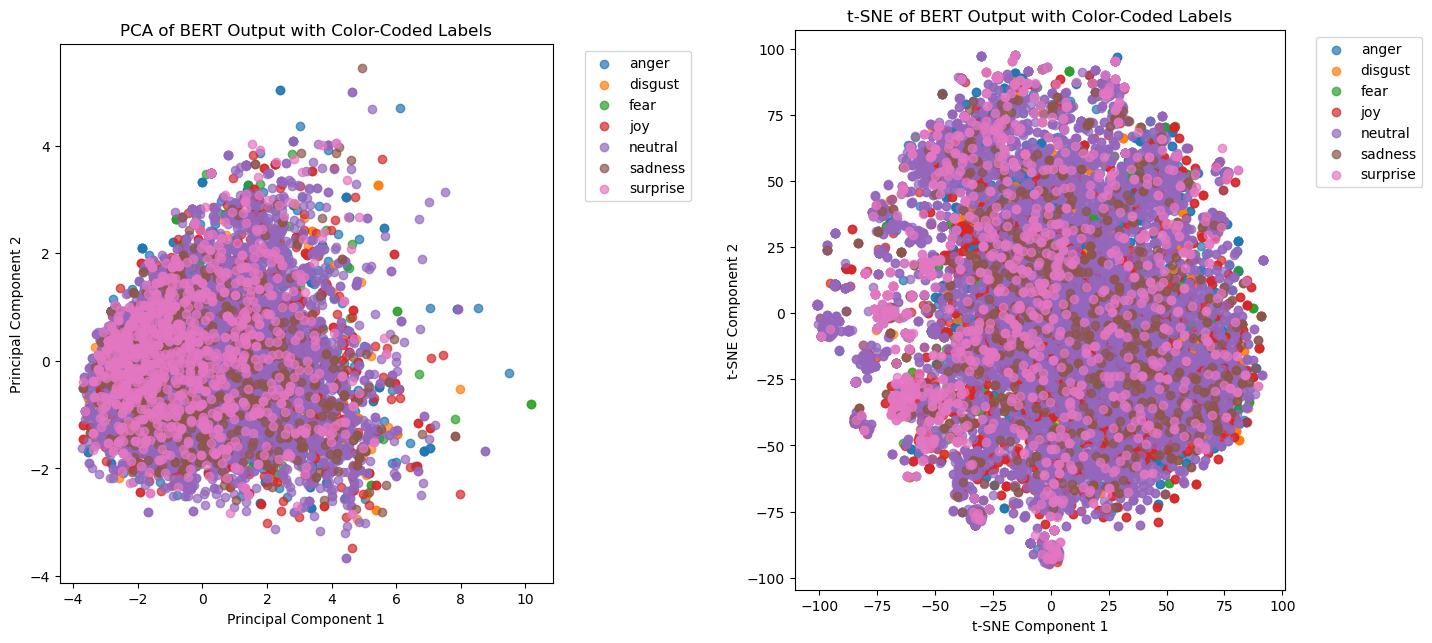

In [116]:
visualize_bert_output(bert_output, y_train['Emotion'])

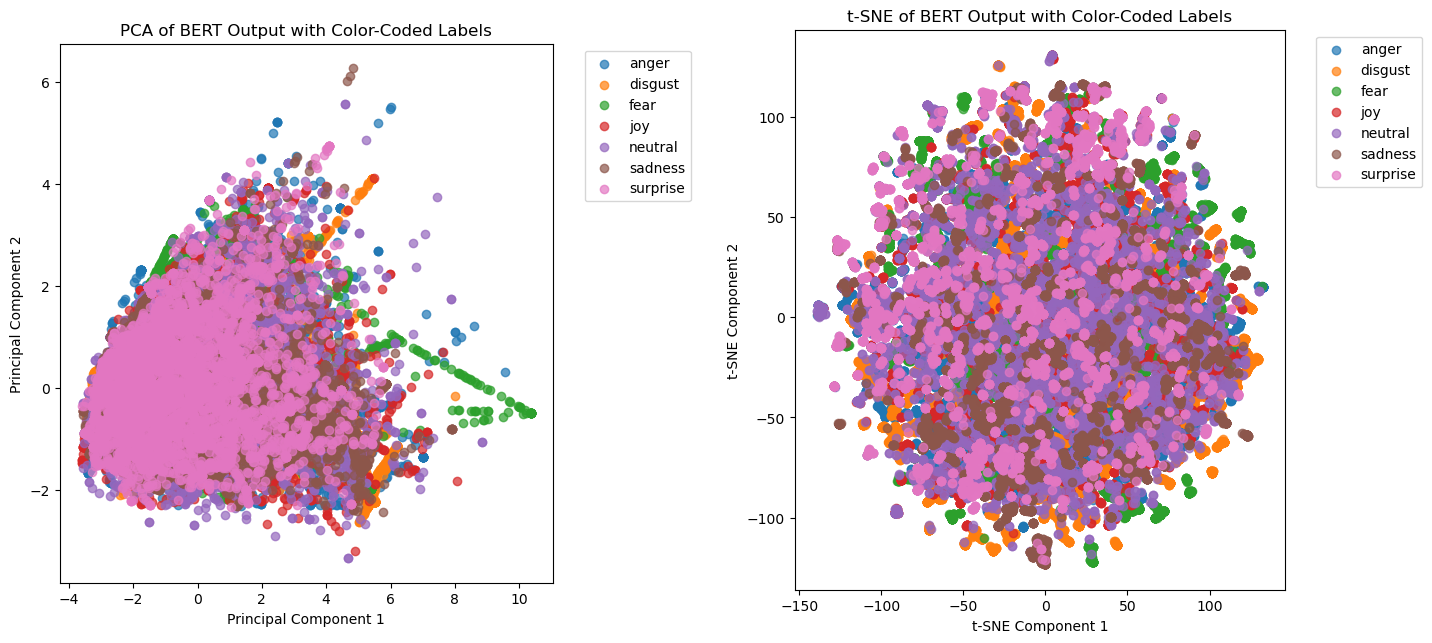

In [117]:
visualize_bert_output(bert_resampled, bert_labels_resampled)

In [112]:
def visualize_cnn_bilstm_output(cnn_bilstm_output, labels):
    """
    Visualizes the CNNBiLSTM output with the corresponding emotion labels using PCA and t-SNE.
    
    Args:
    - cnn_bilstm_output (np.ndarray or torch.Tensor): Output from CNNBiLSTM.
    - labels (list or np.ndarray): Emotion labels for the CNNBiLSTM output.
    - label_decoder (dict): Dictionary to decode labels from integers to emotion names.
    """
    # Check if cnn_bilstm_output is a numpy array or torch tensor
    if isinstance(cnn_bilstm_output, torch.Tensor):
        cnn_bilstm_output_flat = cnn_bilstm_output.view(cnn_bilstm_output.shape[0], -1).detach().numpy()
    else:
        cnn_bilstm_output_flat = cnn_bilstm_output

    # Perform PCA
    pca = PCA(n_components=2)
    output_pca = pca.fit_transform(cnn_bilstm_output_flat)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    output_tsne = tsne.fit_transform(cnn_bilstm_output_flat)
    
    unique_labels = np.unique(labels)

    # Plot PCA and t-SNE results with color-coded labels
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(output_pca[indices, 0], output_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('PCA of CNNBiLSTM Output with Color-Coded Labels')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2, position=[0.65, 0.1, 0.35, 0.8])
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        plt.scatter(output_tsne[indices, 0], output_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('t-SNE of CNNBiLSTM Output with Color-Coded Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()


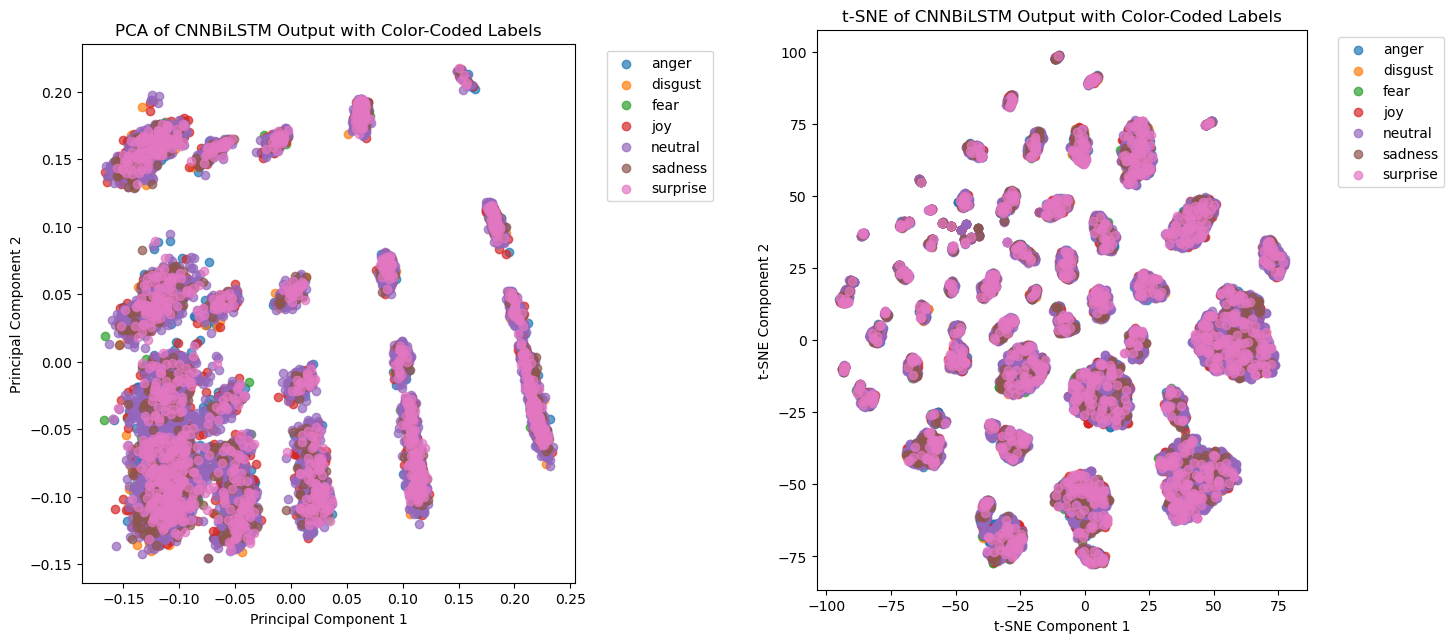

In [113]:
visualize_cnn_bilstm_output(cnn_bilstm_output, y_train['Emotion'])

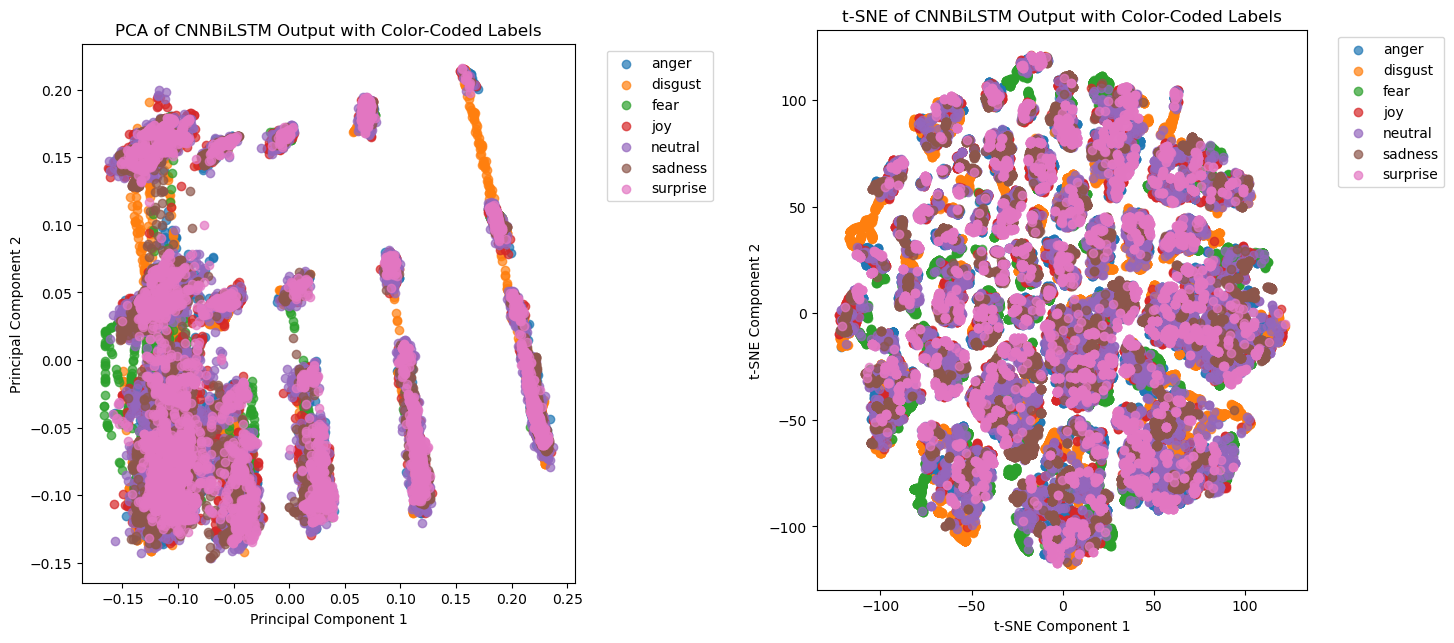

In [114]:
visualize_cnn_bilstm_output(cnn_bilstm_resampled, cnn_bilstm_labels_resampled)

### Archive

In [ ]:
# Get unique labels and their counts for the original and resampled datasets
original_unique_labels, original_label_counts = np.unique(train_labels, return_counts=True)
resampled_unique_labels, resampled_label_counts = np.unique(train_labels_resampled, return_counts=True)

# Create dataframes for the original and resampled class distributions
original_distribution = pd.DataFrame({
    'Label': [labelDecoder[label] for label in original_unique_labels],
    'Occurrences': original_label_counts
})

resampled_distribution = pd.DataFrame({
    'Label': [labelDecoder[label] for label in resampled_unique_labels],
    'Occurrences': resampled_label_counts
})

# Print the shapes of the original and resampled data
print("Original trainContext shape:", trainContext.shape)
print("Resampled trainContext shape:", trainContext_resampled.shape)

# Display the original class distribution
print("\nOriginal class distribution:")
display(original_distribution)

# Display the resampled class distribution
print("\nResampled class distribution:")
display(resampled_distribution)

Original trainContext shape: torch.Size([12176, 1, 200])
Resampled trainContext shape: torch.Size([39522, 1, 200])

Original class distribution:


,Label,Occurrences
0,anger,1445
1,disgust,356
2,fear,320
3,joy,2241
4,neutral,5658
5,sadness,853
6,surprise,1303



Resampled class distribution:


,Label,Occurrences
0,anger,5658
1,disgust,5652
2,fear,5655
3,joy,5637
4,neutral,5618
5,sadness,5648
6,surprise,5654
